In [1]:
import torchvision
from torch import Tensor

from utils import train_vae_classifier
from vae.mnist_vae import  VaeAutoencoderClassifier
from plots import plot_all
from dataset.mnist import prepare_mnist_dataset
from image_classifier.image_classifier import neural_network, train_model, test_model

2024-05-02 10:21:22.512052: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 10:21:23.135945: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
training_data = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=torchvision.transforms.ToTensor())

input = training_data.data[:60000] / 255.0
labels = training_data.targets[:60000]



In [3]:
vae = VaeAutoencoderClassifier(dim_encoding=2)

vae_classifier_model, total_losses, classifier_accuracy_li, classifier_loss_li, vae_loss_li, kl_loss_li = train_vae_classifier(
    vae,
    training_data,
    alpha=5000.0,
    epochs=1
)


0 12583.1064453125; 0 11518.9990234375; 0 11238.1455078125; 0 11543.6484375; 0 10985.720703125; 0 11002.306640625; 0 10956.98828125; 0 10943.1484375; 0 11104.658203125; 

In [4]:
# move tensors to cpu before converting to np array
np_classifier_accuracy_li = []
np_classifier_loss_li = []
np_vae_loss_li = []
np_kl_loss_li = []

for output in classifier_accuracy_li:
    if isinstance(output, Tensor):
        np_classifier_accuracy_li.append(output.cpu().detach().numpy())

for output in classifier_loss_li:
    if isinstance(output, Tensor):
        np_classifier_loss_li.append(output.cpu().detach().numpy())
        
for output in vae_loss_li:
    if isinstance(output, Tensor):
        np_vae_loss_li.append(output.cpu().detach().numpy())

for output in kl_loss_li:
    if isinstance(output, Tensor):
        np_kl_loss_li.append(output.cpu().detach().numpy())


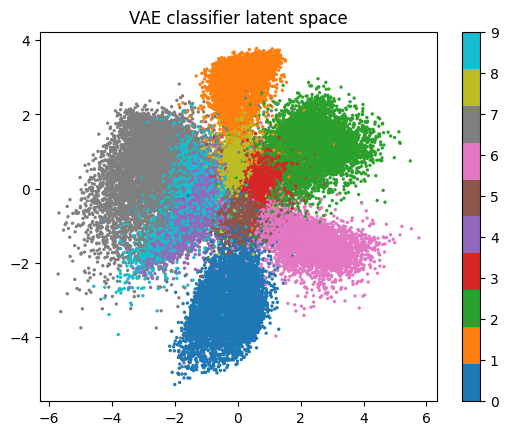

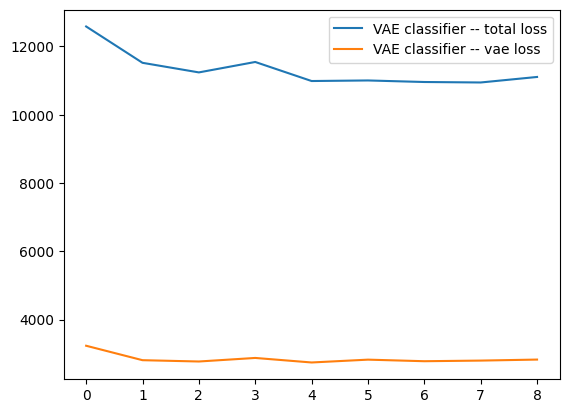

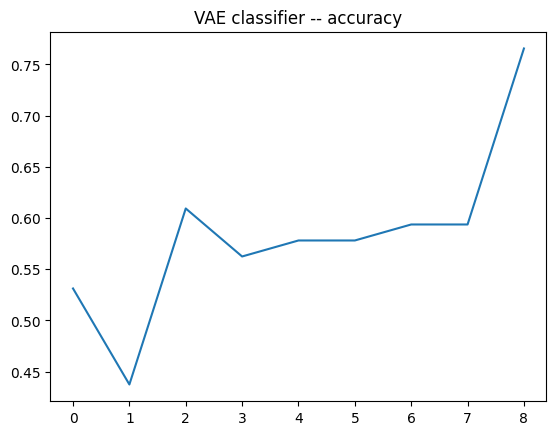

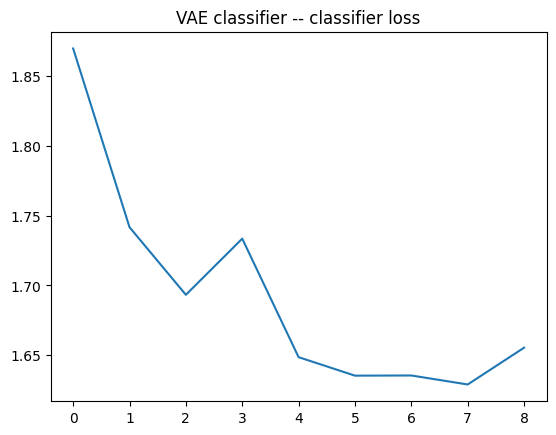

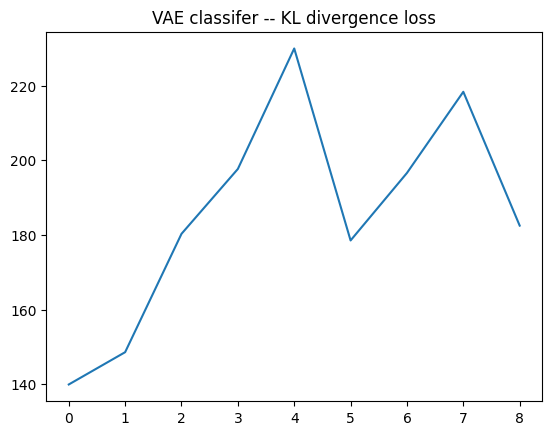

In [5]:
# plot results
plot_all(
    input=input,
    labels=labels,
    vae_model_classifier=vae_classifier_model,
    vae_loss_li=np_vae_loss_li,
    total_losses=total_losses, 
    classifier_accuracy_li=np_classifier_accuracy_li, 
    classifier_loss_li=np_classifier_loss_li,
    kl_loss_li=np_kl_loss_li
)

In [6]:
# train classifier for performance evaluation

x_train, x_test, y_train, y_test = prepare_mnist_dataset()
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

# nn_model = neural_network(10, 784)
# train_model(nn_model, x_train, y_train)
# test_model(nn_model, x_test, y_test)

Training images size:  56000
Training input size: 784
Training labels size: 56000
Testing images size:  14000
Testing input size: 784
Testing labels size: 14000
Normalized result (56000, 784) (14000, 784)
Output shape (56000, 10)
(56000, 784)
(14000, 784)
(56000, 10)
(14000, 10)


In [7]:
vae.generate_data()
# x = x.to('cpu')
# y = y.to('cpu')
# print(x.shape)
# print(y.shape)


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)